### Emotion Detection and Recognition

Emotion Detection and Recognition from text is closely related to Sentiment Analysis which aims to detect and recognize various types of feelings through the expression of texts, such as anger, disgust, fear, happiness, sadness, and surprise unlike sentiment analysis which detects positive, neutral, or negative feelings from text. 

For this project, we will be using [ISEAR](https://docs.google.com/spreadsheets/d/1stzD5sXgRpyf-YWCV805XlUJIA2XpOG1FzdzX_GS8Jk/edit?usp=sharing) dataset with column_names: Emotions and Sentence. Let's import the packages and read the csv file.

In [1]:
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords

In [2]:
column_names = ['Emotions', 'Sentence']
df = pd.read_csv('ISEAR.csv', names = column_names)
df.head()

,Emotions,Sentence
joy,On days when I feel close to my partner and ot...,NaN
fear,Every time I imagine that someone I love or I ...,NaN
anger,When I had been obviously unjustly treated and...,NaN
sadness,When I think about the short time that we live...,NaN
disgust,At a gathering I found myself involuntarily si...,NaN


The columns are not assigned properly in our data. The last column is redundant and the first column is displayed as an index. So, let us first clean the data.

### Data Cleaning

In [3]:
del df['Sentence']
df = df.reset_index()
df.rename(index=str, columns={"index": "Emotions", "Emotions": "Sentence"}, inplace=True)
df.head()

,Emotions,Sentence
0,joy,On days when I feel close to my partner and ot...
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...


Our columns are correctly assigned now. Let us observe the number of emotions we need to classify and list them.

In [4]:
print("We need to classify "+ str(df.Emotions.nunique()) +" emotions.")
print("The emotions to be classified are: "+ str(list(df.Emotions.unique().tolist())))

We need to classify 8 emotions.
The emotions to be classified are: ['joy', 'fear', 'anger', 'sadness', 'disgust', 'shame', 'guilt', 'guit']


As seen above, the emotion 'guit' seems to be incorrect. There is a spelling error. So, let us replace guit by guilt and then, classify the 7 emotions.

In [5]:
df['Emotions'].replace('guit','guilt', inplace=True)
print("We need to classify "+ str(df.Emotions.nunique()) +" emotions now.")
print("The emotions to be classified are: "+ str(list(df.Emotions.unique())))

We need to classify 7 emotions now.
The emotions to be classified are: ['joy', 'fear', 'anger', 'sadness', 'disgust', 'shame', 'guilt']


Let us assign the unique emotions as a list to target_names.

In [6]:
target_names = list(df.Emotions.unique())
target_names

['joy', 'fear', 'anger', 'sadness', 'disgust', 'shame', 'guilt']

Now, let us check if any values of a dataframe contains null.

In [7]:
check_null = df.isnull().values.any()
check_null

False

As <b>check_null = False</b>, there are no null values. So, further cleaning of the null values need not be done.

We will now display the information and some description of our data.

In [8]:
print("The shape of our data is "+ str(df.shape))

The shape of our data is (7516, 2)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7516 entries, 0 to 7515
Data columns (total 2 columns):
Emotions    7516 non-null object
Sentence    7516 non-null object
dtypes: object(2)
memory usage: 176.2+ KB


In [10]:
df.describe()

,Emotions,Sentence
count,7516,7516
unique,7,7449
top,joy,When my grandfather died.
freq,1092,8


Now, let's assign the first column to X and the emotions depicted to y.

In [11]:
X, y = df['Sentence'], df['Emotions']

We will use count vectorizer and Tf-idf to extract the important features from our sentence.

### Tf-idf

Tf-idf stands for term frequency-inverse document frequency. The tf-idf weight is a statistical measure used to evaluate how important a word is to a document in a corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

Tf-idf can be successfully used for stop-words filtering in various subject fields including text summarization and classification. 

For a term t in a document d, the weight Wt,d of term t in document d is given by:

                Wt,d = TFt,d log (N/DFt)

Where:

TFt,d is the number of occurrences of t in document d.
<br>DFt is the number of documents containing the term t.
<br>N is the total number of documents in the corpus.

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test  =  train_test_split(X, y, test_size=0.008, random_state=101)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer().fit(X)
X_vect_train = vectorizer.transform(X_train)

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer
X_transformed = TfidfTransformer(use_idf=True).fit(X_vect_train)
X_transformed_train = X_transformed.transform(X_vect_train)

Let's now change our output to one hot encoded form.

In [ ]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y)
encoded_y_train = encoder.transform(y_train)
# convert integers to one hot encoded
y_categorical_train = np_utils.to_categorical(encoded_y_train)

In [16]:
X_vect_test = vectorizer.transform(X_test)
X_transformed_test = TfidfTransformer(use_idf=True).fit_transform(X_vect_test)
encoded_y_test = encoder.transform(y_test)
y_categorical_test = np_utils.to_categorical(encoded_y_test)

We will implement six classification algorithms of sklearn package:

1. MultinomialNB
2. GaussianNB
3. LogisticRegression
4. RandomForestClassifier
5. Decision Trees
6. Extra Trees

### 1. MultinomialNB (Naive Bayes)

In [17]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_transformed_train, np.argmax(y_categorical_train,1))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [18]:
pred_nb = nb.predict(X_transformed_test)

We will check the accuracy of our model using confusion matrix, classification report and accuracy score.

In [19]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
np.set_printoptions(precision=2)

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as sm
dict_accuracy_score = {}
def check_metrics(pred, model):
    y = np.argmax(y_categorical_test, 1)
    accuracy_score = sm.accuracy_score(y, pred)
    cm = confusion_matrix(y, pred)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=target_names,title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()
    print('\n')

    print("Classification report is")
    
    print(classification_report(y, pred))
    print()
    print("Accuracy score is ", str(accuracy_score))
    dict_accuracy_score[model] = accuracy_score

Confusion matrix, without normalization
[[ 2  2  1  3  0  0  0]
 [ 1  4  1  0  0  0  1]
 [ 0  0  7  0  0  0  0]
 [ 0  0  0  4  1  0  1]
 [ 0  0  0  2 11  1  1]
 [ 2  0  1  0  2  5  0]
 [ 0  0  0  2  0  0  6]]
Normalized confusion matrix
[[0.25 0.25 0.12 0.38 0.   0.   0.  ]
 [0.14 0.57 0.14 0.   0.   0.   0.14]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.67 0.17 0.   0.17]
 [0.   0.   0.   0.13 0.73 0.07 0.07]
 [0.2  0.   0.1  0.   0.2  0.5  0.  ]
 [0.   0.   0.   0.25 0.   0.   0.75]]


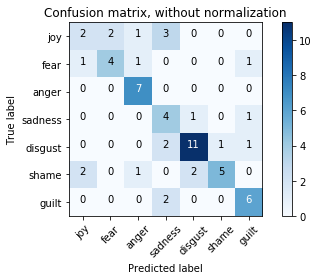

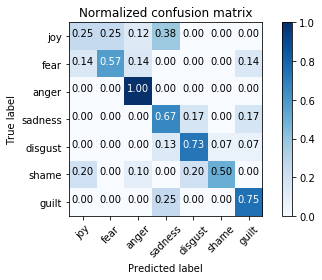



Classification report is
             precision    recall  f1-score   support

          0       0.40      0.25      0.31         8
          1       0.67      0.57      0.62         7
          2       0.70      1.00      0.82         7
          3       0.36      0.67      0.47         6
          4       0.79      0.73      0.76        15
          5       0.83      0.50      0.62        10
          6       0.67      0.75      0.71         8

avg / total       0.66      0.64      0.63        61


Accuracy score is  0.639344262295082


In [21]:
check_metrics(pred_nb, "Naive Bayes")

### 2. Gaussian Naive Bayes

In [22]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_transformed_train.toarray(), np.argmax(y_categorical_train,1))
pred_gnb = gnb.predict(X_transformed_test.toarray())

Let us now check the accuracy of gaussian naive bayes classifier.

Confusion matrix, without normalization
[[0 2 2 1 0 2 1]
 [0 5 0 0 0 0 2]
 [0 0 4 1 0 0 2]
 [1 1 0 1 0 2 1]
 [2 0 1 1 8 3 0]
 [0 0 0 1 4 5 0]
 [1 1 0 1 0 1 4]]
Normalized confusion matrix
[[0.   0.25 0.25 0.12 0.   0.25 0.12]
 [0.   0.71 0.   0.   0.   0.   0.29]
 [0.   0.   0.57 0.14 0.   0.   0.29]
 [0.17 0.17 0.   0.17 0.   0.33 0.17]
 [0.13 0.   0.07 0.07 0.53 0.2  0.  ]
 [0.   0.   0.   0.1  0.4  0.5  0.  ]
 [0.12 0.12 0.   0.12 0.   0.12 0.5 ]]


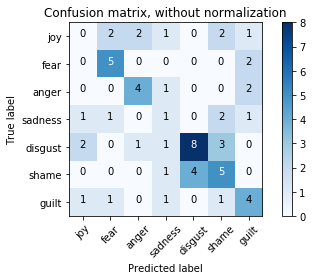

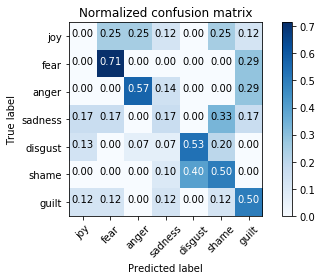



Classification report is
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         8
          1       0.56      0.71      0.63         7
          2       0.57      0.57      0.57         7
          3       0.17      0.17      0.17         6
          4       0.67      0.53      0.59        15
          5       0.38      0.50      0.43        10
          6       0.40      0.50      0.44         8

avg / total       0.43      0.44      0.43        61


Accuracy score is  0.4426229508196721


In [23]:
check_metrics(pred_gnb, "Gaussian Naive Bayes")

### 3. Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_transformed_train, np.argmax(y_categorical_train,1))
pred_lr = lr.predict(X_transformed_test)

Let us now check the performance metrics of logistic regression.

Confusion matrix, without normalization
[[ 4  2  1  1  0  0  0]
 [ 1  6  0  0  0  0  0]
 [ 0  0  7  0  0  0  0]
 [ 0  0  0  4  0  1  1]
 [ 2  0  0  1 10  1  1]
 [ 1  1  0  0  1  6  1]
 [ 1  0  0  1  1  0  5]]
Normalized confusion matrix
[[0.5  0.25 0.12 0.12 0.   0.   0.  ]
 [0.14 0.86 0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.67 0.   0.17 0.17]
 [0.13 0.   0.   0.07 0.67 0.07 0.07]
 [0.1  0.1  0.   0.   0.1  0.6  0.1 ]
 [0.12 0.   0.   0.12 0.12 0.   0.62]]


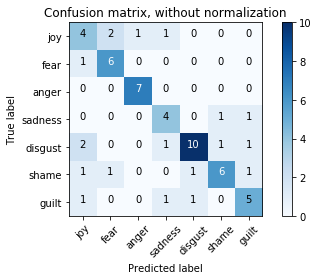

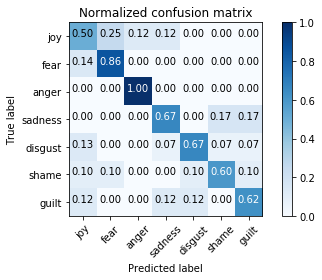



Classification report is
             precision    recall  f1-score   support

          0       0.44      0.50      0.47         8
          1       0.67      0.86      0.75         7
          2       0.88      1.00      0.93         7
          3       0.57      0.67      0.62         6
          4       0.83      0.67      0.74        15
          5       0.75      0.60      0.67        10
          6       0.62      0.62      0.62         8

avg / total       0.70      0.69      0.69        61


Accuracy score is  0.6885245901639344


In [25]:
check_metrics(pred_lr, "Logistic Regression")

### 4. Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500, max_depth=20,random_state=0)
rfc.fit(X_transformed_train, np.argmax(y_categorical_train,1))
pred_rfc = rfc.predict(X_transformed_test)

We will now check the performance metrics of random forest classifier.

Confusion matrix, without normalization
[[ 4  1  0  3  0  0  0]
 [ 1  5  0  0  0  0  1]
 [ 0  1  6  0  0  0  0]
 [ 0  0  0  4  1  1  0]
 [ 1  1  0  0 12  0  1]
 [ 2  0  0  0  1  6  1]
 [ 1  1  0  1  1  0  4]]
Normalized confusion matrix
[[0.5  0.12 0.   0.38 0.   0.   0.  ]
 [0.14 0.71 0.   0.   0.   0.   0.14]
 [0.   0.14 0.86 0.   0.   0.   0.  ]
 [0.   0.   0.   0.67 0.17 0.17 0.  ]
 [0.07 0.07 0.   0.   0.8  0.   0.07]
 [0.2  0.   0.   0.   0.1  0.6  0.1 ]
 [0.12 0.12 0.   0.12 0.12 0.   0.5 ]]


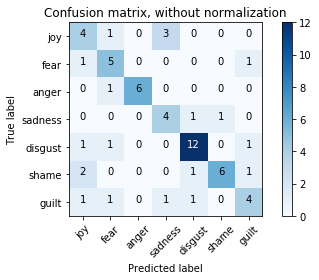

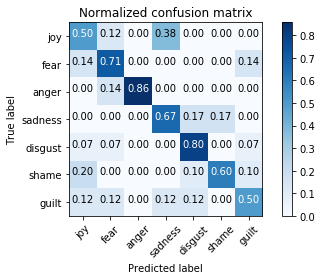



Classification report is
             precision    recall  f1-score   support

          0       0.44      0.50      0.47         8
          1       0.56      0.71      0.63         7
          2       1.00      0.86      0.92         7
          3       0.50      0.67      0.57         6
          4       0.80      0.80      0.80        15
          5       0.86      0.60      0.71        10
          6       0.57      0.50      0.53         8

avg / total       0.70      0.67      0.68        61


Accuracy score is  0.6721311475409836


In [27]:
check_metrics(pred_rfc, "Random Forest Classifier")

### 5. Decision Tree

In [28]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt.fit(X_transformed_train, np.argmax(y_categorical_train,1))
pred_dt = dt.predict(X_transformed_test)

Confusion matrix, without normalization
[[3 0 1 3 1 0 0]
 [0 2 1 0 1 0 3]
 [0 0 4 1 0 0 2]
 [1 0 0 4 0 1 0]
 [3 1 1 1 8 0 1]
 [0 2 0 0 0 7 1]
 [0 1 1 1 0 1 4]]
Normalized confusion matrix
[[0.38 0.   0.12 0.38 0.12 0.   0.  ]
 [0.   0.29 0.14 0.   0.14 0.   0.43]
 [0.   0.   0.57 0.14 0.   0.   0.29]
 [0.17 0.   0.   0.67 0.   0.17 0.  ]
 [0.2  0.07 0.07 0.07 0.53 0.   0.07]
 [0.   0.2  0.   0.   0.   0.7  0.1 ]
 [0.   0.12 0.12 0.12 0.   0.12 0.5 ]]


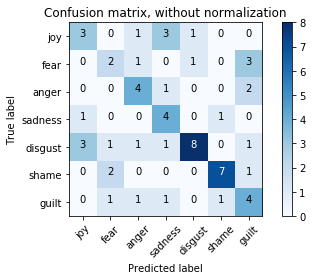

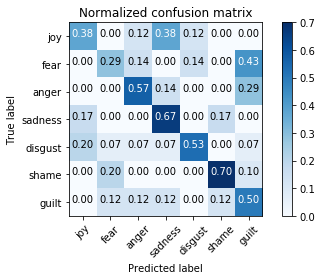



Classification report is
             precision    recall  f1-score   support

          0       0.43      0.38      0.40         8
          1       0.33      0.29      0.31         7
          2       0.50      0.57      0.53         7
          3       0.40      0.67      0.50         6
          4       0.80      0.53      0.64        15
          5       0.78      0.70      0.74        10
          6       0.36      0.50      0.42         8

avg / total       0.56      0.52      0.53        61


Accuracy score is  0.5245901639344263


In [29]:
# Check performance metrics of decision tree model.
check_metrics(pred_dt, "Decision tree")

### 6. Extra Trees

In [30]:
from sklearn.ensemble import ExtraTreesClassifier
forest = ExtraTreesClassifier(n_estimators=500, max_depth=20, random_state=0)
forest.fit(X_transformed_train, np.argmax(y_categorical_train,1))
pred_forest = forest.predict(X_transformed_test)

Confusion matrix, without normalization
[[ 4  1  0  3  0  0  0]
 [ 1  5  0  0  1  0  0]
 [ 0  0  7  0  0  0  0]
 [ 0  0  0  4  0  1  1]
 [ 1  1  0  0 12  1  0]
 [ 2  0  0  0  1  6  1]
 [ 0  1  0  2  1  1  3]]
Normalized confusion matrix
[[0.5  0.12 0.   0.38 0.   0.   0.  ]
 [0.14 0.71 0.   0.   0.14 0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.67 0.   0.17 0.17]
 [0.07 0.07 0.   0.   0.8  0.07 0.  ]
 [0.2  0.   0.   0.   0.1  0.6  0.1 ]
 [0.   0.12 0.   0.25 0.12 0.12 0.38]]


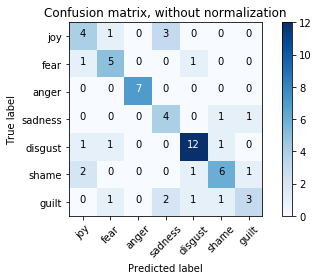

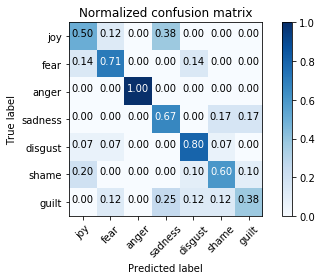



Classification report is
             precision    recall  f1-score   support

          0       0.50      0.50      0.50         8
          1       0.62      0.71      0.67         7
          2       1.00      1.00      1.00         7
          3       0.44      0.67      0.53         6
          4       0.80      0.80      0.80        15
          5       0.67      0.60      0.63        10
          6       0.60      0.38      0.46         8

avg / total       0.68      0.67      0.67        61


Accuracy score is  0.6721311475409836


In [31]:
# Check performance metrics of extra trees model.
check_metrics(pred_forest, "Extra trees")

Let us compare different models used for classification now.

In [32]:
s  = pd.Series(dict_accuracy_score,index=dict_accuracy_score.keys())
s

Naive Bayes                 0.639344
Gaussian Naive Bayes        0.442623
Logistic Regression         0.688525
Random Forest Classifier    0.672131
Decision tree               0.524590
Extra trees                 0.672131
dtype: float64

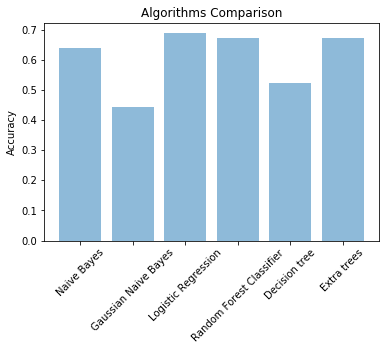

In [33]:
objects = dict_accuracy_score.keys()
y_pos = np.arange(len(objects))
performance = dict_accuracy_score.values()
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=45)
plt.ylabel('Accuracy')
plt.title('Algorithms Comparison')
 
plt.show()

So, logistic regression classifies the emotions more accurately than other algorithms in our case.

We will now tune the hyperparameters of our Logistic Regression model using EvolutionaryAlgorithmSearchCV and see if we can further increase the accuracy.

In [34]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'multinomial',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [35]:
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

In [36]:
from evolutionary_search import EvolutionaryAlgorithmSearchCV
clf = EvolutionaryAlgorithmSearchCV(lr, param_grid, cv=5)
clf.fit(X_transformed_train, np.argmax(y_categorical_train,1))

Let's check if the best parameters generated by evolutionary search is different from our default parameters.

In [37]:
clf.best_estimator_

LogisticRegression(C=3.727593720314938, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

So, the new value of C is approx. 3.73. Let us now check the performance metrics with the new C.

In [38]:
pred_lr_tuned = clf.predict(X_transformed_test)

Confusion matrix, without normalization
[[ 3  2  1  1  0  0  1]
 [ 0  6  0  0  0  0  1]
 [ 0  0  7  0  0  0  0]
 [ 0  0  0  5  0  0  1]
 [ 1  0  0  1 11  1  1]
 [ 1  1  0  0  1  7  0]
 [ 0  0  0  1  1  1  5]]
Normalized confusion matrix
[[0.38 0.25 0.12 0.12 0.   0.   0.12]
 [0.   0.86 0.   0.   0.   0.   0.14]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.83 0.   0.   0.17]
 [0.07 0.   0.   0.07 0.73 0.07 0.07]
 [0.1  0.1  0.   0.   0.1  0.7  0.  ]
 [0.   0.   0.   0.12 0.12 0.12 0.62]]


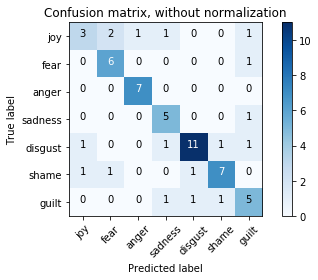

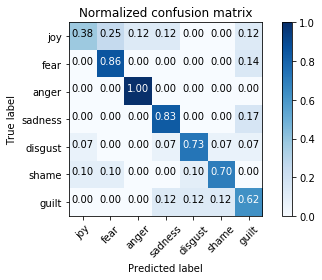



Classification report is
             precision    recall  f1-score   support

          0       0.60      0.38      0.46         8
          1       0.67      0.86      0.75         7
          2       0.88      1.00      0.93         7
          3       0.62      0.83      0.71         6
          4       0.85      0.73      0.79        15
          5       0.78      0.70      0.74        10
          6       0.56      0.62      0.59         8

avg / total       0.73      0.72      0.72        61


Accuracy score is  0.7213114754098361


In [39]:
check_metrics(pred_lr_tuned, "Logistic Regression with new C param")

We have now increased the accuracy of Logistic Regression model by approx. 4%.

Let us increase the complexity of our network using LSTM and word embeddings so as to classify emotions more effectively and accurately.

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences

In [41]:
# Split the sentences into words
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(sequences, maxlen=50)

In [42]:
tokenizer.fit_on_texts(X_test)
sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences, maxlen=50)

In [43]:
# Network architecture
model = Sequential()
model.add(Embedding(20000, 100, input_length=50, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(7, activation='sigmoid', kernel_regularizer=regularizers.l2(0.02)))

In [44]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
# Set callback functions to early stop training and save the best model so far
from keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [46]:
## Fit the model
model.fit(X_train, y_categorical_train, validation_split=0.3, epochs=3, callbacks=callbacks)
score = model.evaluate(X_test, y_categorical_test, verbose=2) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 5218 samples, validate on 2237 samples
Epoch 1/3
5218/5218 [==============================] - 11s 2ms/step - loss: 0.7566 - acc: 0.8499 - val_loss: 0.4998 - val_acc: 0.8571
Epoch 2/3
5218/5218 [==============================] - 11s 2ms/step - loss: 0.4541 - acc: 0.8574 - val_loss: 0.4593 - val_acc: 0.8579
Epoch 3/3
5218/5218 [==============================] - 10s 2ms/step - loss: 0.4102 - acc: 0.8679 - val_loss: 0.4555 - val_acc: 0.8666
Test score: 0.5051963202288894
Test accuracy: 0.8618267178535461


Thus, using deep neural networks, we are able to increase our test accuracy to approx. 86%